**Predicting the presence of exoplanets at Kepler objects of interest.
NASA data from the Kepler telescope.**

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi

The goal of my work is to train an algorithm to predict the most likely candidates among the observed objects for exoplanets. Such work will be useful for other orbital research missions (and future missions) looking for planets in other stellar systems, such as the TESS orbiting telescope.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anshumancos","key":"ee4ef52af43b83fc3e8a0b3fe73bf367"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d nasa/kepler-exoplanet-search-results

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 80.6MB/s]


In [ ]:
!unzip kepler-exoplanet-search-results

Archive:  kepler-exoplanet-search-results.zip
  inflating: cumulative.csv          


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
df = pd.read_csv('cumulative.csv', delimiter=',')
df.head(10)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,11.094321,2.036000e-05,-2.036000e-05,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,4.59450,0.06100,-0.06100,1517.5,24.2,-24.2,3.90,1.27,-0.42,835.0,NaN,NaN,114.81,112.85,-36.70,66.5,1.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,4.134435,1.046000e-05,-1.046000e-05,172.979370,0.001900,-0.001900,0.762,0.139,-0.532,3.14020,0.06730,-0.06730,686.0,18.7,-18.7,2.77,0.90,-0.30,1160.0,NaN,NaN,427.65,420.33,-136.70,40.2,2.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
7,8,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,0,2.566589,1.781000e-05,-1.781000e-05,179.554370,0.004610,-0.004610,0.755,0.212,-0.523,2.42900,0.16500,-0.16500,226.5,16.8,-16.8,1.59,0.52,-0.17,1360.0,NaN,NaN,807.74,793.91,-258.20,15.0,3.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
8,9,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,7.361790,2.128000e-05,-2.128000e-05,132.250530,0.002530,-0.002530,1.169,7.133,-0.044,5.02200,0.13600,-0.13600,233.7,5.8,-5.8,39.21,6.45,-9.67,1342.0,NaN,NaN,767.22,349.28,-365.49,47.7,1.0,q1_q17_dr25_tce,6227.0,111.0,-124.0,3.986,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660
9,10,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,16.068647,1.088000e-05,-1.088000e-05,173.62193

In [ ]:
nRow, nCol = df.shape
print(f"Rows: {nRow}, Columns: {nCol}")

Rows: 9564, Columns: 50


In [ ]:
df.dtypes

rowid                  int64
kepid                  int64
kepoi_name            object
kepler_name           object
koi_disposition       object
koi_pdisposition      object
koi_score            float64
koi_fpflag_nt          int64
koi_fpflag_ss          int64
koi_fpflag_co          int64
koi_fpflag_ec          int64
koi_period           float64
koi_period_err1      float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err1      float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_depth_err1       float64
koi_depth_err2       float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq              float64
koi_teq_err1         float64
koi_teq_err2         float64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2


# String data:

In [ ]:
Categorical_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
Categorical_cols

['koi_tce_delivname',
 'koi_disposition',
 'kepler_name',
 'kepoi_name',
 'koi_pdisposition']

Reference for column defintions: https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html

kepoi_name: Kepler object of interest (KOI) name has an integer and a decimal part in the format KNNNNN.DD. The integer part identifies the target star; the two-digit decimal part identifies the unique transiting object associated with that star. 

kepler_name: The name of the object as "Kepler-H" plus a lowercase letter denoting the planet. Intended to clearly indicate the class of objects that have been confirmed or approved as planets - a step up from the planet candidate designation.

koi_disposition: A textual description of the candidate exoplanet. 3 values - CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED (Objects are labeled CANDIDATE, as they require re-registration by ground-based telescopes to be confirmed planets. They are then given CONFIRMED status. NOT DISPOSITIONED status means there is not enough data on the object yet).

koi_pdisposition: A value that represents the most likely physical explanation for the Kepler object of interest. Typical values are FALSE POSITIVE, NOT DISPOSITIONED and CANDIDATE. The value of this flag may change over time as the KOI estimate moves to deeper levels of analysis using pixel and Kepler time series light curve data or subsequent observations.

koi_tce_delivname - The delivery name in the threshold crossing event (TCE) information corresponding to the TCE data integrated into the KOI.

Also, the koi_score parameter is highlighted separately in the dataset description:

This is a value between 0 and 1 that indicates the validity of the KOI location. For CANDIDATES, a higher value indicates more confidence in its location, while for FALSE, a higher value indicates less confidence in that location.

It is clear from the dataset description that only objects that are CONFIRMED candidates for exoplanets have names (kepler_name). Those objects where the presence of exoplanets is not confirmed have no names (NaN). The value of each item will be unique.

**Therefore, the kepler_name column can be removed; it is irrelevant for further prediction**


In [ ]:
df[["kepler_name", "koi_disposition", 'koi_pdisposition']].head(20)

,kepler_name,koi_disposition,koi_pdisposition
0,Kepler-227 b,CONFIRMED,CANDIDATE
1,Kepler-227 c,CONFIRMED,CANDIDATE
2,NaN,FALSE POSITIVE,FALSE POSITIVE
3,NaN,FALSE POSITIVE,FALSE POSITIVE
4,Kepler-664 b,CONFIRMED,CANDIDATE
5,Kepler-228 d,CONFIRMED,CANDIDATE
6,Kepler-228 c,CONFIRMED,CANDIDATE
7,Kepler-228 b,CONFIRMED,CANDIDATE
8,NaN,FALSE POSITIVE,FALSE POSITIVE
9,Kepler-229 c,CONFIRMED,CANDIDATE


In [ ]:
df = df.drop('kepler_name', 1, errors='ignore')
df

,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,NaN,NaN,176.40,152.77,-77.60,8.4,1.0,q1_q17_dr25_tce,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,453.3,1.0,q1_q17_dr25_tce,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,10.6,1.0,q1_q17_dr25_tce,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,12.3,1.0,q1_q17_dr25_tce,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.11

# Let's look at the distribution of the koi_pdisposition and koi_disposition parameters:

In [ ]:
df.assign(n=0).groupby(['koi_pdisposition']).n.count()

koi_pdisposition
CANDIDATE         4496
FALSE POSITIVE    5068
Name: n, dtype: int64

In [ ]:
df.assign(n=0).groupby(['koi_disposition']).n.count()

koi_disposition
CANDIDATE         2248
CONFIRMED         2293
FALSE POSITIVE    5023
Name: n, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


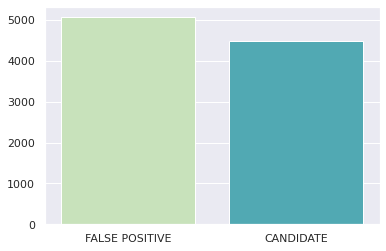

In [ ]:
import seaborn as sns
sns.set()

with sns.color_palette("YlGnBu", 3):
    sns.barplot(df['koi_pdisposition'].value_counts().index, df['koi_pdisposition'].value_counts().values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


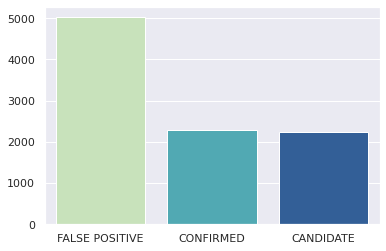

In [ ]:
 with sns.color_palette("YlGnBu", 3):
        sns.barplot(df['koi_disposition'].value_counts().index, df['koi_disposition'].value_counts().values)

We see that the data has no gaps. Each column contains a total of 9564 values.

koi_pdisposition contains only CANDIDATE and FALSE POSITIVE values.

koi_disposition contains the values ​​CANDIDATE, CONFIRMED, and FALSE POSITIVE.

We also see that 45 objects have not confirmed their CANDIDATE status, and have moved to the FALSE POSITIVE status.

2248 objects from the dataset still remain in an unconfirmed state, that is, CANDIDATE.


# Also look at the koi_tce_delivname parameter:

In [ ]:
df["koi_tce_delivname"].head(5)

0    q1_q17_dr25_tce
1    q1_q17_dr25_tce
2    q1_q17_dr25_tce
3    q1_q17_dr25_tce
4    q1_q17_dr25_tce
Name: koi_tce_delivname, dtype: object

# Let's see if this column has unique or repeating values:

In [ ]:
df["koi_tce_delivname"].unique()

array(['q1_q17_dr25_tce', 'q1_q16_tce', nan, 'q1_q17_dr24_tce'],
      dtype=object)


Threshold Crossing Event (TCE) are the delivery names in the information, which are also available on the official website of NASA Exoplanet Science Institute. 

For further training of the model, they will also not be important.

In [ ]:
df = df.drop('koi_tce_delivname', 1, errors='ignore')
df

,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,NaN,NaN,176.40,152.77,-77.60,8.4,1.0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


#Let's make several visualizations of the objects under study
(These are based on some astronomers' analyses we have studied)

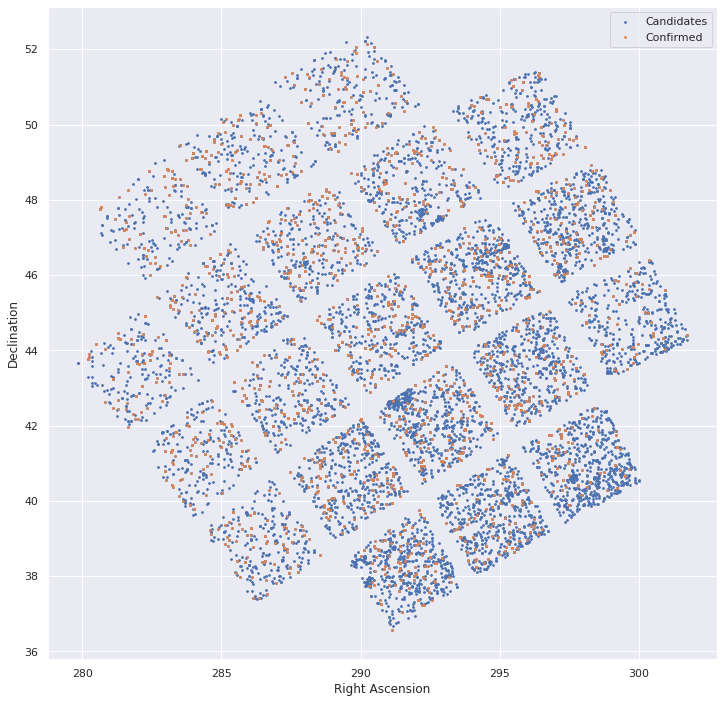

In [ ]:
import matplotlib.pyplot as plt

confirmed = df[df.koi_disposition == 'CONFIRMED']

ra, dec = df.ra, df.dec
ra_c, dec_c = confirmed.ra, confirmed.dec

fig = plt.figure(figsize=(12, 12))

plt.scatter(ra, dec, s=3, label='Candidates')
plt.scatter(ra_c, dec_c, s=3, label="Confirmed")

plt.xlabel("Right Ascension")
plt.ylabel("Declination")

plt.legend()

The density of stars increases to the side, that is, closer to the bulge of the Milky Way.

It is also interesting to note that, with an increase in the density of the arrangement of stars in space (closer to the center of the arm of the Milky Way), the density of the number of confirmed planets does not increase. Most likely, this is due to the difficulty of conducting observations in a denser area of ​​outer space.


Text(0.5, 0, 'Orbital period of confirmed planets, (days)')

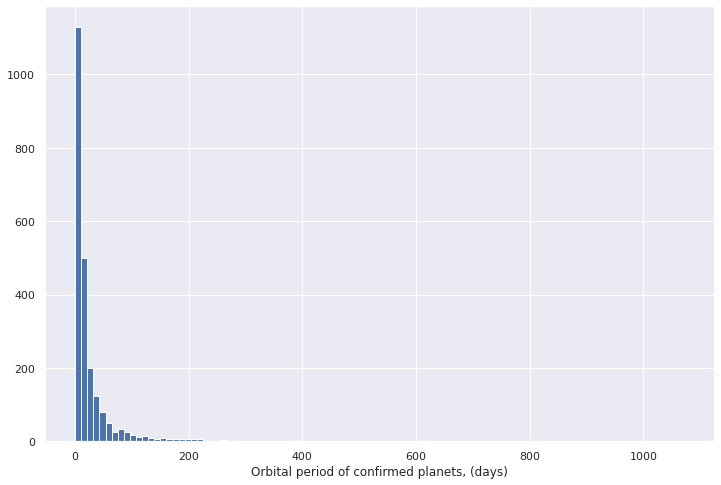

In [ ]:
ax = confirmed.koi_period.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Orbital period of confirmed planets, (days)")

From above graph we see that most of the confirmed planets have lower orbital periods. 
This makes sense, since the lower the orbital period, the more likely it will be to eclipse it's star (and therefore the more likely it will be observed).

Text(0.5, 1.0, 'Surface gravity of stars with confirmed planets')

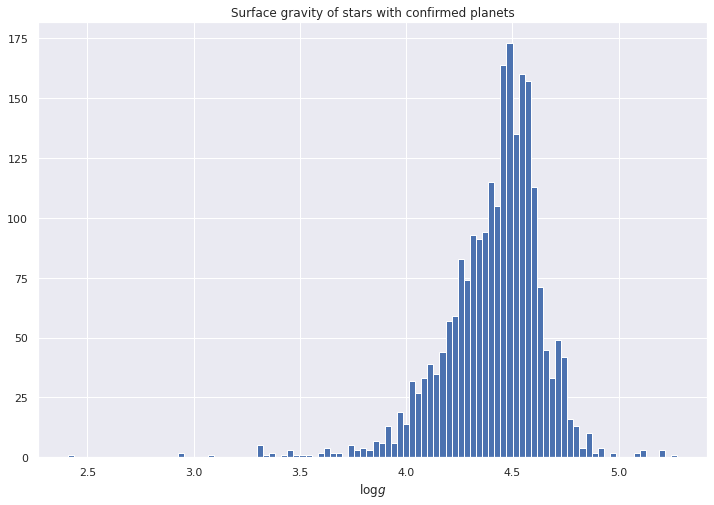

In [ ]:
ax = confirmed.koi_slogg.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("$\log{g}$")
ax.set_title("Surface gravity of stars with confirmed planets")


The gravity of most objects is in the range of 3.5 ... 5 g 
(log (9.81) is perimeterly equal to 1, so we can ignore log(g)).

Text(0.5, 1.0, 'Сonfirmed')

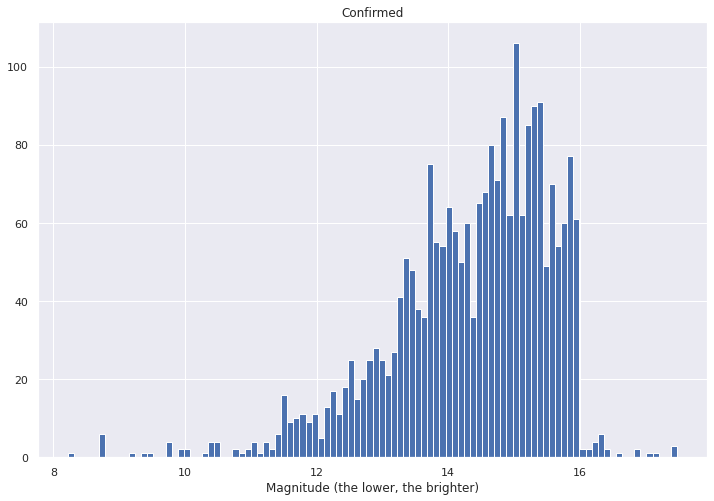

In [ ]:
ax = confirmed.koi_kepmag.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Magnitude (the lower, the brighter)")
ax.set_title("Сonfirmed")

We see a sharp decline around the 16th magnitude. 
This seems to be the limit at which the noise gets too much to detect planetary candidates.

#There are 2 options for further research.
#1) We choose koi_pdisposition as the target variable and train our model to recognize the most probable CANDIDATE objects.

#2) We choose koi_disposition as the target variable and train our model to recognize the most likely CONFIRMED objects.

Since the share of error between CANDIDATE and CONFIRMED is quite small (45 / (2293 + 45)) x100% = 1.92%, we have decided to choose option 1. After all, assignment of the CONFIRMED status.

So, we will classify objects only as either CANDIDATE or FALSE POSITIVE.

In [ ]:
# Now we will recode categorical features for further analysis

from sklearn import preprocessing

# Let's write a function that accepts DataFrame as input, encode categorical features with numeric values and returns the updated DataFrame and the encoders themselves.

def nef(init_df):
    result = init_df.copy() # copy of our original table
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # if the column type is a string, then it is encoded
            encoders[column] = preprocessing.LabelEncoder() # creating an encoder for the column
            result[column] = encoders[column].fit_transform(result[column]) # apply the encoder to the column and overwrite the column
    return result, encoders

encoded_data, encoders = nef(df) # Now encoded data contains encoded categorical signs 
encoded_data.head() 

,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,1080,1,0,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,1081,1,0,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,1082,2,1,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,1083,2,1,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,1084,1,0,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509



#Correlation matrix:

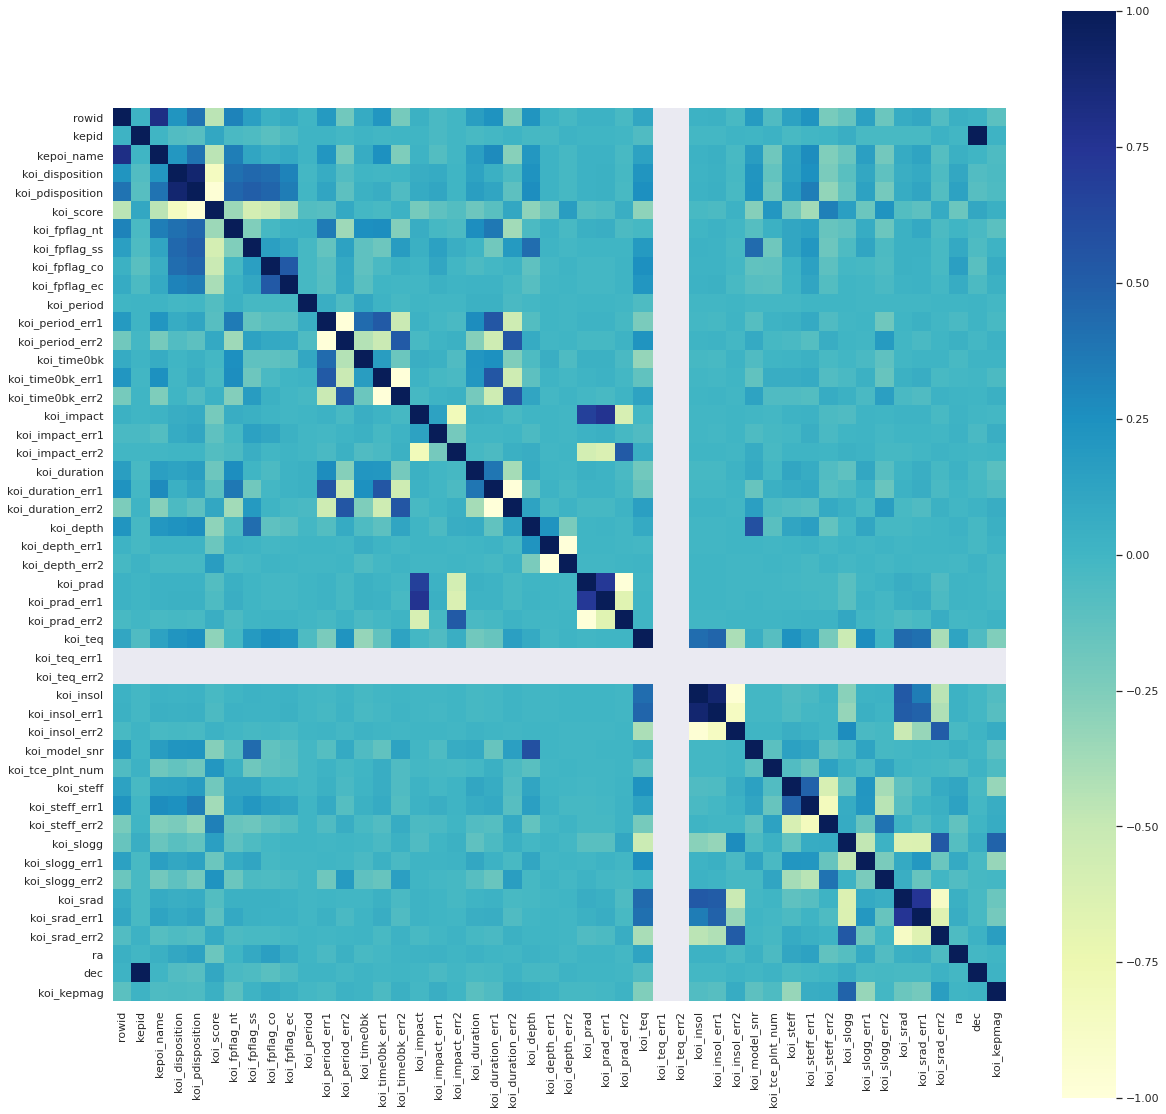

In [ ]:
plt.subplots(figsize=(20,20))
sns.heatmap(encoded_data.corr(), square=True, cmap="YlGnBu")
plt.show()

From the correlation matrix, it can be seen that kepid is fully correlated with dec.

dec is the KIC (Kepler Input Catalog) Declination - 

Kepler Input Catalog: Photometric Calibration and Star Classification.

So, we conclude that KepId tells us the type of star we are observing.

In [ ]:
encoded_data[['kepid', 'dec']].head(20)

,kepid,dec
0,10797460,48.141651
1,10797460,48.141651
2,10811496,48.134129
3,10848459,48.285210
4,10854555,48.226200
5,10872983,48.224670
6,10872983,48.224670
7,10872983,48.224670
8,6721123,42.151569
9,10910878,48.375790


We can remove the kepId column since, Dec already tells us the type of star.

In [ ]:
encoded_data = encoded_data.drop('kepid', 1, errors='ignore')
encoded_data

,rowid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1080,1,0,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,1081,1,0,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,1082,2,1,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,1083,2,1,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,1084,1,0,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,9248,2,1,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,NaN,NaN,176.40,152.77,-77.60,8.4,1.0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,9249,2,1,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,9250,0,0,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,9251,2,1,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


Also, two columns koi_teq_err1, koi_teq_err2 have no data at all..

In [ ]:
print(encoded_data['koi_teq_err1'].unique())
print(encoded_data['koi_teq_err2'].unique())

[nan]
[nan]


 So, we can delete these columns

In [ ]:
encoded_data.drop(['koi_teq_err1', 'koi_teq_err2'], 1, errors='ignore', inplace = True)
encoded_data

,rowid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1080,1,0,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,1081,1,0,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,1082,2,1,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,1083,2,1,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,1084,1,0,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,9248,2,1,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,176.40,152.77,-77.60,8.4,1.0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,9249,2,1,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,9250,0,0,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,9251,2,1,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385



We can also remove the koi_disposition parameter (since we decided to use koi_pdisposition earlier).

In addition, the koi_pdisposition and koi_disposition data are highly correlated with each other.

Also, we can safely remove the rowid and kepoi_name columns ( they are just column numbers and object names).

In [ ]:
encoded_data.drop(['koi_disposition', 'rowid', 'kepoi_name'], 1, errors='ignore', inplace = True)
encoded_data

,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,0,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,1,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,1,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,0,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,1,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,176.40,152.77,-77.60,8.4,1.0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,1,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,0,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,1,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385



# Let's look at the distribution of values ​​by features in our data:

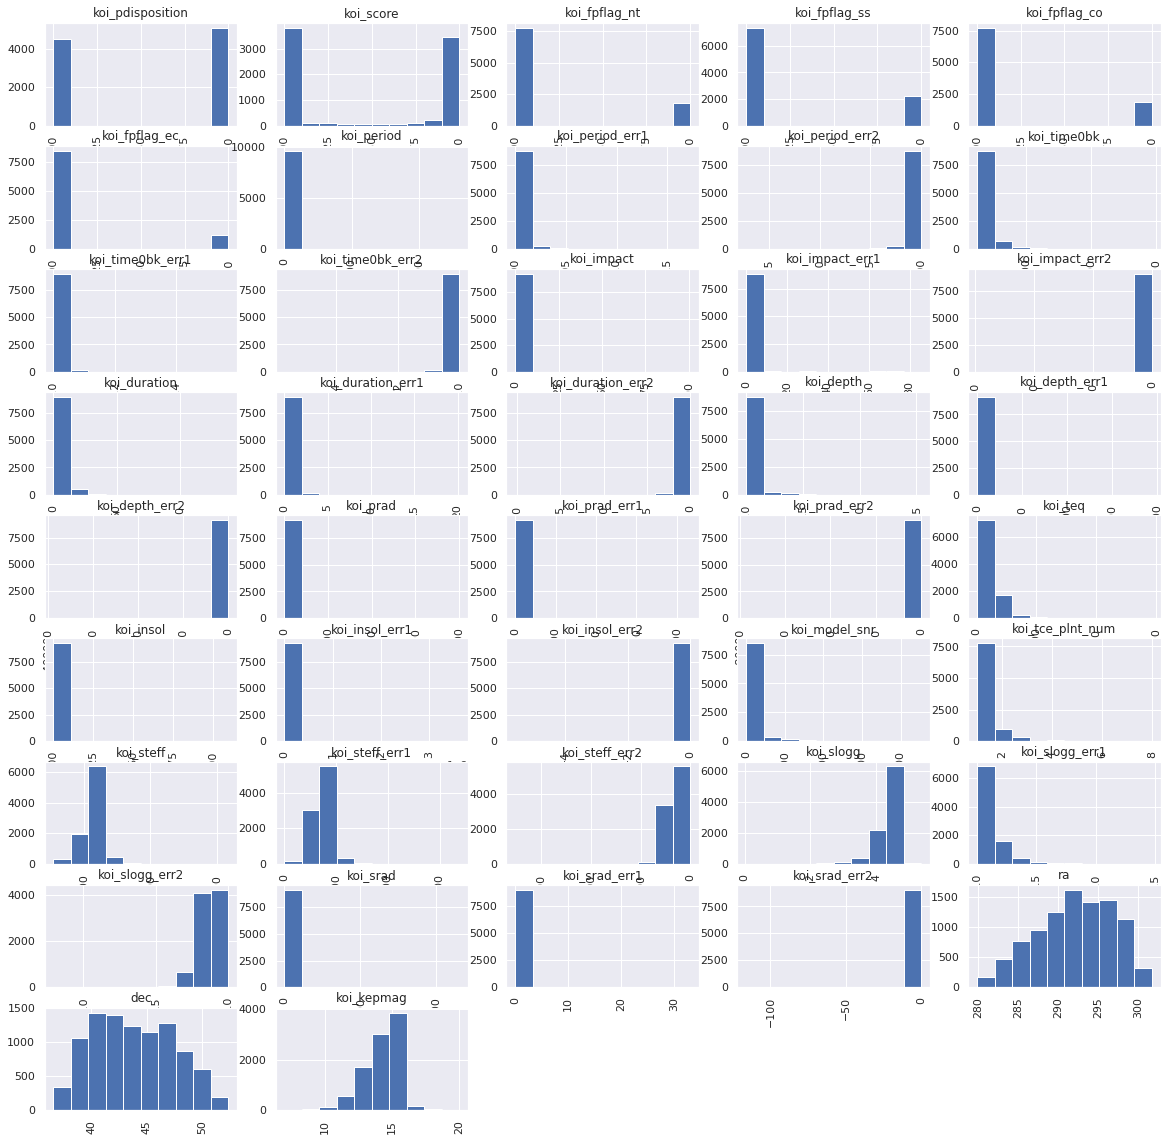

In [ ]:
fig = plt.figure(figsize=(20,20))
cols = 5

rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")

# Let's look at the gaps in our dataset

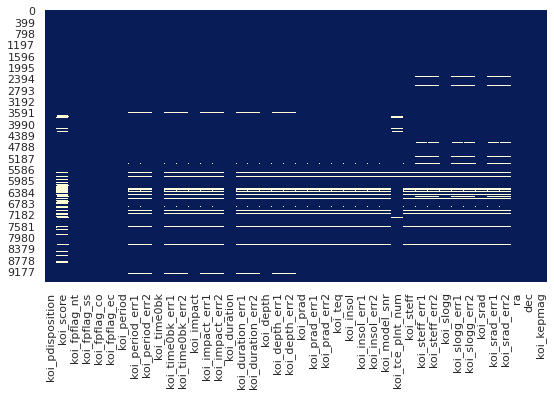

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(encoded_data.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [ ]:
missing_val_count_by_column = encoded_data.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column > 0])

koi_score            1510
koi_period_err1       454
koi_period_err2       454
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad              363
koi_srad_err1         468
koi_srad_err2         468
koi_kepmag              1
dtype: int64


In [ ]:
encoded_data['koi_tce_plnt_num'].unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.])

We see that many characteristics have missing values.

Most of the omissions are in the koi_score parameter. 

As we remember from the description, it is a value between 0 and 1, which indicates the reliability of the Kepler object of interest location.It basically tells us the same thing as the koi_pdisposition. So, it can be removed from the dataset.

koi_tce_plnt_num - exoplanet number, according to the NASA documentation is just an indicator so it can also be excluded.

The other missing characteristics are:

the impact parameter (the distance projected to the sky between the center of the stellar disk and the center of the disk of the planet in conjunction, normalized by the stellar radius), 

the transit depth, 

the planetary radius, 

the insolation flux, 

the transit signal-noise, 

the photospheric temperature of the star, 

and the uncertainty values.

In [ ]:
encoded_data.drop('koi_tce_plnt_num', 1, errors='ignore', inplace = True)

In [ ]:
encoded_data['koi_score']

0       1.000
1       0.969
2       0.000
3       0.000
4       1.000
        ...  
9559    0.000
9560    0.000
9561    0.497
9562    0.021
9563    0.000
Name: koi_score, Length: 9564, dtype: float64

In [ ]:
encoded_data.drop('koi_score', 1, errors='ignore', inplace = True)

The following flags are not clearly documented but training the model with these flags gave us very high accuracy indicating they may directly indicate if the observation has an exoplanet or not. So they have to be removed.

In [ ]:
encoded_data.drop(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], 1, errors='ignore', inplace = True)
encoded_data

,koi_pdisposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,1,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,1,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,176.40,152.77,-77.60,8.4,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,1,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,453.3,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,10.6,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,1,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,12.3,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385



# Our target variable - koi_pdisposition is binary.
# Let's see how the classes are encoded

In [ ]:
enc1 = encoders['koi_pdisposition'].transform(['FALSE POSITIVE'])
enc2 = encoders['koi_pdisposition'].transform(['CANDIDATE'])
print(f'CANDIDATE status is encoded as {enc1}')
print(f'FALSE POSITIVE status is encoded as{enc2}') 

CANDIDATE status is encoded as [1]
FALSE POSITIVE status is encoded as[0]


# Now, we select a separate variable for koi_pdisposition and remove it from the training set

In [ ]:
y = np.array(encoded_data['koi_pdisposition'].astype('int64'))
encoded_data.drop('koi_pdisposition', 1, errors='ignore', inplace = True)
encoded_data

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,176.40,152.77,-77.60,8.4,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,453.3,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,10.6,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,12.3,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385



#Imputation
To fill in the missing data, we use imputation. Imputation fills in the missing value with some number. We experimented with this and found it gives more accurate models than dropping the column altogether.

In [ ]:
# the name of the dataframe columns will be written to the dummies_columns variable
dummies_columns = list(encoded_data.columns)
print(dummies_columns)

['koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']


In [ ]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

In [ ]:
data_with_imputed_values = my_imputer.fit_transform(encoded_data)
data_with_imputed_values.shape

(9564, 35)

In [ ]:
# Let's write the resulting array completely into our dataframe
encoded_data=pd.DataFrame(data_with_imputed_values)
encoded_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [ ]:
# Checking if the data is clean now
missing_val_count_by_column = encoded_data.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)



# Creating training set X

In [ ]:
X = np.array(encoded_data[encoded_data._get_numeric_data().columns])
X

array([[ 9.48803557e+00,  2.77500000e-05, -2.77500000e-05, ...,
         2.91934230e+02,  4.81416510e+01,  1.53470000e+01],
       [ 5.44183827e+01,  2.47900000e-04, -2.47900000e-04, ...,
         2.91934230e+02,  4.81416510e+01,  1.53470000e+01],
       [ 1.98991399e+01,  1.49400000e-05, -1.49400000e-05, ...,
         2.97004820e+02,  4.81341290e+01,  1.54360000e+01],
       ...,
       [ 1.73984941e+00,  1.78000000e-05, -1.78000000e-05, ...,
         2.86509370e+02,  4.71632190e+01,  1.47570000e+01],
       [ 6.81401611e-01,  2.43400000e-06, -2.43400000e-06, ...,
         2.94164890e+02,  4.71762810e+01,  1.53850000e+01],
       [ 4.85603482e+00,  6.35600000e-05, -6.35600000e-05, ...,
         2.97009770e+02,  4.71210210e+01,  1.48260000e+01]])

# Shuffling the sample.
We find by y the indices of objects that belong to the FALSE POSITIVE class and for having a balanced mix cut *it* to the size of CANDIDATE.

In [ ]:
FALSE_POSITIVE = np.argwhere(y == 1).flatten()
print('Number of FALSE POSITIVEs', len(FALSE_POSITIVE))
FALSE_POSITIVE

Number of FALSE POSITIVEs 5068


array([   2,    3,    8, ..., 9560, 9562, 9563])

We shuffled the array with a selected random state (so that in the future we have the same samples);
We selected the "extra" id FALSE POSITIVE in it (that spoils the algorithm's accuracy)

Number of "extra" = number FALSE POSITIVE - number of CANDIDATE.

In [ ]:
from sklearn.utils import shuffle

FALSE_POSITIVE = shuffle(FALSE_POSITIVE, random_state = 42)
# find the "extra" ones, for this we cut the found id by the number of CANDIDATE (inside len)
FALSE_POSITIVE = FALSE_POSITIVE[:len(np.argwhere(y == 0).flatten())]
print(len(FALSE_POSITIVE))
# display the number and the id themselves, which we should throw out
FALSE_POSITIVE

4496


array([9244, 7647, 8227, ..., 8876, 8970, 3937])

Checking if the classes are balanced now.

In [ ]:
len(np.argwhere(y == 0).flatten()) == len(FALSE_POSITIVE)

True


Now we can select only the desired id with y = 0 and 1

In [ ]:
X = X[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]
y = y[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]

Displaying the final size of the dataset features 

X - Training set

Y - Output feature (koi_pdisposition)

In [ ]:
X.shape, y.shape

((8992, 35), (8992,))

In [ ]:
pd.Series(y).value_counts()

1    4496
0    4496
dtype: int64

In [ ]:
y = np.array(y, int)
y

array([1, 1, 1, ..., 0, 0, 0])

#Normalizing the data

In [ ]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[-0.05303712, -0.25969395,  0.25969395, ..., -1.13671969,
         0.52061231, -0.40564058],
       [-0.05330886,  0.00949337, -0.00949337, ...,  0.43738288,
         0.21987346,  0.50706023],
       [-0.02192235, -0.25945657,  0.25945657, ...,  0.74574626,
        -0.17581542, -1.95326369],
       ...,
       [-0.04805489, -0.25857523,  0.25857523, ..., -0.39179131,
         1.78156388, -0.49654991],
       [-0.02026363, -0.23539128,  0.23539128, ...,  0.86720528,
         0.30451851, -0.38688151],
       [-0.0532372 , -0.25747505,  0.25747505, ..., -1.15466083,
         0.92740786,  0.35338017]])

In [ ]:
X_scaled.shape, y.shape

((8992, 35), (8992,))

# Dividing the data into test (15%) and training (85%) sets

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.15, random_state = 0)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (7643, 35)
Shape of y_train : (7643,)
Shape of x_test : (1349, 35)
Shape of y_test : (1349,)


Now we tried the most common binary classifiers:

logistic regression, 

decision tree, 

random forest, 

nearest neighbors (KNN) method.

We also used a neural network.


#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# We initialize the algorithm
knn = KNeighborsClassifier()

# Sklearn has a special module for working with cross-validation
from sklearn.model_selection import GridSearchCV

# Let's set a grid - among which values ​​to choose the best parameter.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')} # iterate over the parameter <<n_neighbors>>, on the grid specified by np.linspace (2, 100, 10)

# Create a cross-validation object
gs = GridSearchCV(knn, knn_grid, cv=5)

# We train the model
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Graph drawing function

In [ ]:
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):  
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    # x - the number of neighbors, y - accuracy
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

A graph of the dependence of quality on the number of neighbors

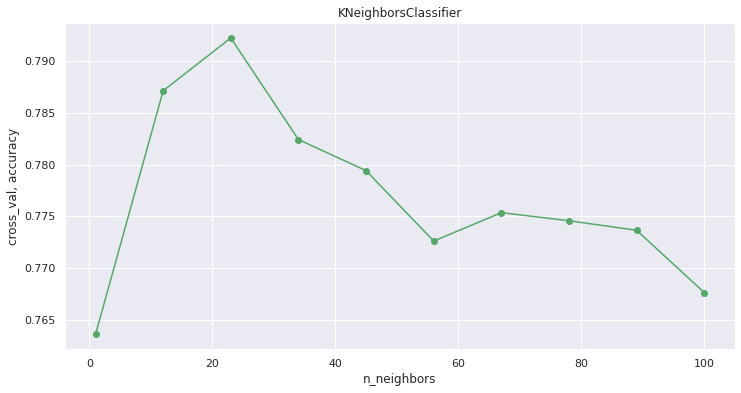

In [ ]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

Best parameter

In [ ]:
gs.best_params_, gs.best_score_

({'n_neighbors': 23}, 0.7922273223781756)

We get the conclusion that the most optimal parameters are around the level of 15-30 neighbors.

In [ ]:
# Let's set a grid - among which values ​​to choose the best parameter.
knn_grid = {'n_neighbors': list(range(15, 30))} # iterate over the parameter <<n_neighbors>>, along the grid specified by np.linspace (2, 100, 10)

# Create a cross-validation object
gs = GridSearchCV(knn, knn_grid, cv=5)

# We train the model
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                         25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

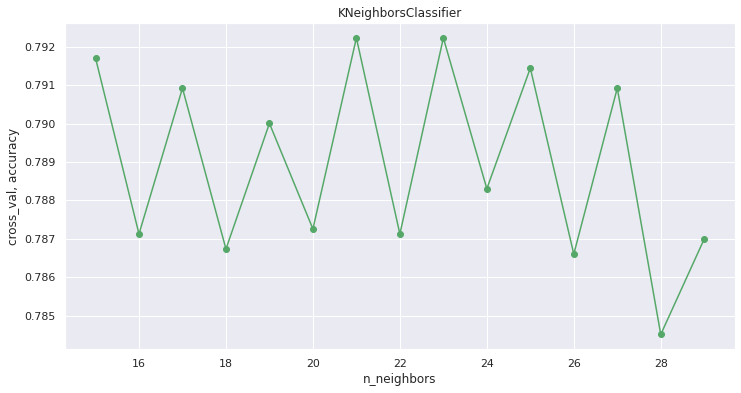

In [ ]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [ ]:
gs.best_params_, gs.best_score_

({'n_neighbors': 21}, 0.7922274935881852)

In [ ]:
predictions = gs.predict(x_test)
predictions

array([0, 1, 1, ..., 1, 0, 1])

Let's look at quality metrics via classification report

In [ ]:
from sklearn import metrics
clf_knn = knn.fit(x_train, y_train)
y_knn = clf_knn.predict(x_test)
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       679
           1       0.80      0.73      0.76       670

    accuracy                           0.78      1349
   macro avg       0.78      0.78      0.78      1349
weighted avg       0.78      0.78      0.78      1349



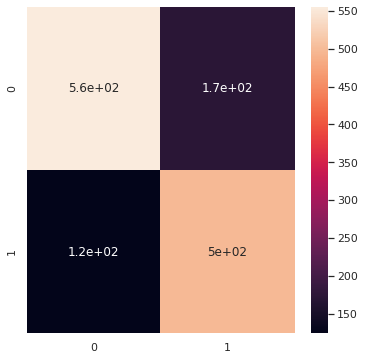

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(predictions, y_test)

plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
grid={"C": np.logspace(-2, 4, 20), "penalty":["l2"] }
# initialize the algorithm
logreg = LogisticRegression(max_iter=10000)

logreg_cv = GridSearchCV(logreg, grid, cv=5)

# learning
logreg_cv.fit(x_train, y_train)

logreg_cv.best_params_, logreg_cv.best_score_

({'C': 4832.930238571752, 'penalty': 'l2'}, 0.8053123041785515)

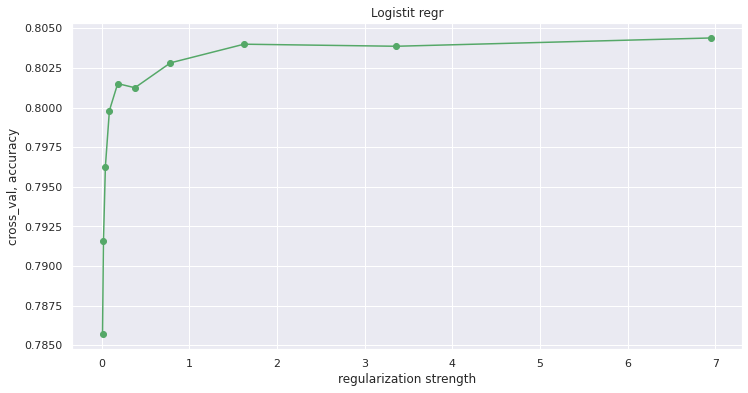

In [ ]:
grid_plot(logreg_cv.cv_results_['param_C'][:10], logreg_cv.cv_results_['mean_test_score'][:10], 'regularization strength', 'Logistit regr')

In [ ]:
predictions = logreg_cv.predict(x_test)
predictions

array([1, 1, 1, ..., 1, 0, 0])

Plotting the ROC curve  (False Positive Rate(FPR) v/s True Positive Rate(TPR))

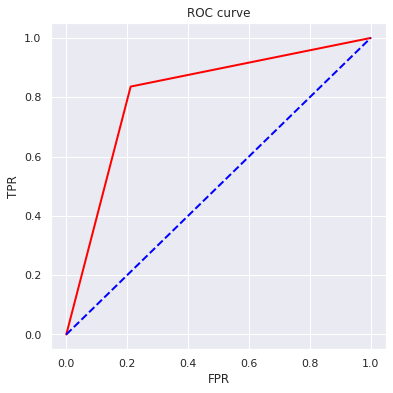

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr,_= roc_curve(predictions, y_test, drop_intermediate=False)

plt.figure()
# Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
# Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
# Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       733
           1       0.77      0.84      0.80       616

    accuracy                           0.81      1349
   macro avg       0.81      0.81      0.81      1349
weighted avg       0.81      0.81      0.81      1349



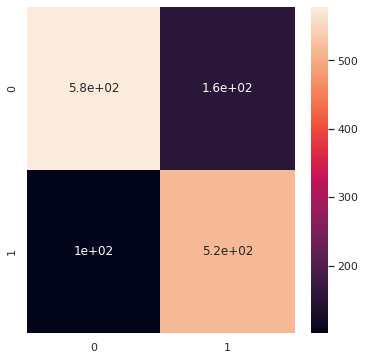

In [ ]:
# confusion matrix

cm = confusion_matrix(predictions, y_test)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(predictions, y_test)
print(cr)


# Decision tree

In [ ]:
from sklearn import tree

In [ ]:
param_grid = {'min_samples_split': [i for i in range(2, 100)] }
alg = tree.DecisionTreeClassifier()
gs = GridSearchCV(alg, param_grid, cv=10)
gs.fit(x_train, y_train)

# best_params_ contains the best matched parameters, best_score_ contains the best quality
gs.best_params_, gs.best_score_

({'min_samples_split': 69}, 0.8032231461520036)

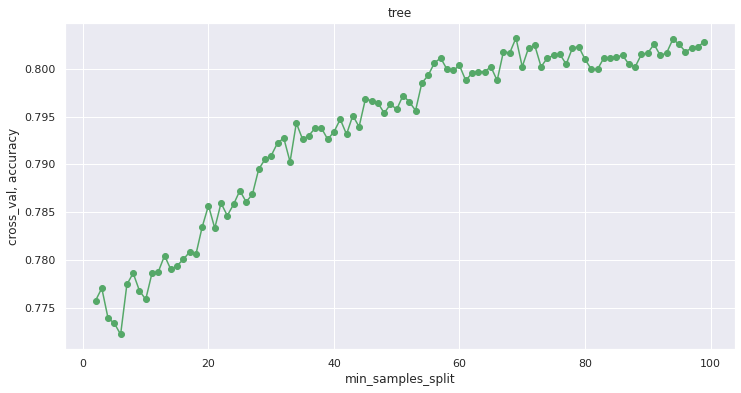

In [ ]:
grid_plot(param_grid['min_samples_split'], gs.cv_results_['mean_test_score'], 'min_samples_split', 'tree')

In [ ]:
predictions = gs.predict(x_test)
predictions

array([1, 1, 1, ..., 1, 0, 1])

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       673
           1       0.83      0.82      0.82       676

    accuracy                           0.82      1349
   macro avg       0.82      0.82      0.82      1349
weighted avg       0.82      0.82      0.82      1349



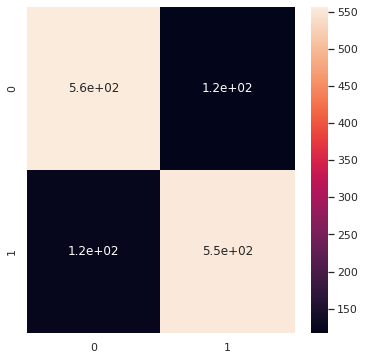

In [ ]:
cm = confusion_matrix(predictions, y_test)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(predictions, y_test)
print(cr)

# Random forest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# iterate over depth
# iterate over the min number to split
# maximum number of features for a more random sample
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(x_train[0])-1]
              }

# initialize a random forest with brute force on the cross-shaft on the parameters selected above
alg = RandomForestClassifier()
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
gs.fit(x_train, y_train)

# best_params_ contains the best matched parameters, best_score_ the best quality
print()
gs.best_params_, gs.best_score_

({'max_depth': 11, 'max_features': 34, 'min_samples_split': 4},
 0.8424706118018485)

In [ ]:
predictions = gs.predict(x_test)
predictions

array([1, 1, 1, ..., 1, 0, 1])

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       664
           1       0.85      0.83      0.84       685

    accuracy                           0.84      1349
   macro avg       0.84      0.84      0.84      1349
weighted avg       0.84      0.84      0.84      1349



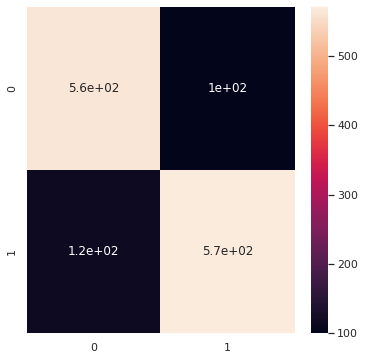

In [ ]:
cm = confusion_matrix(predictions, y_test)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(predictions, y_test)
print(cr)

In [ ]:
def plot_feature_importances(model, columns):
    # select the number of features to display
    nr_f = 10
    # we take data for the graph
    # take an algorithm with the best parameters
    # by x, we take the importance of features based on the Gini criterion, sort them along with the column names in ascending order
    imp = pd.Series(data = model.best_estimator_.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    # build a figure
    plt.figure(figsize=(7,5))
    # display the title
    plt.title("The importance of signs | Feature importance")
    # built the 10 most important signs
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')

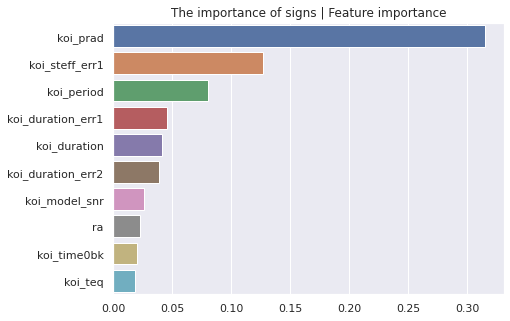

In [ ]:
plot_feature_importances(gs, dummies_columns)

#Neural Network

In [ ]:
# Neural network.
# import serial model
from keras.models import Sequential
# import the mesh layer
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=35, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss="mean_squared_error",optimizer='adam', metrics=["binary_accuracy"]) 

In [ ]:
# train a model with a batch in 32, in 50 epochs, check by test
history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs=50,
                    batch_size=32)
# final check
results = model.evaluate(x_test, y_test)
print("Test loss and accuracy", results)

Epoch 1/50
239/239 [==============================] - 4s 4ms/step - loss: 0.1790 - binary_accuracy: 0.7400 - val_loss: 0.1358 - val_binary_accuracy: 0.8102
Epoch 2/50
239/239 [==============================] - 1s 2ms/step - loss: 0.1254 - binary_accuracy: 0.8294 - val_loss: 0.1315 - val_binary_accuracy: 0.8154
Epoch 3/50
239/239 [==============================] - 1s 2ms/step - loss: 0.1140 - binary_accuracy: 0.8438 - val_loss: 0.1235 - val_binary_accuracy: 0.8325
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.1079 - binary_accuracy: 0.8515 - val_loss: 0.1245 - val_binary_accuracy: 0.8236
Epoch 5/50
239/239 [==============================] - 1s 2ms/step - loss: 0.1060 - binary_accuracy: 0.8573 - val_loss: 0.1306 - val_binary_accuracy: 0.8117
Epoch 6/50
239/239 [==============================] - 1s 2ms/step - loss: 0.1023 - binary_accuracy: 0.8589 - val_loss: 0.1270 - val_binary_accuracy: 0.8288
Epoch 7/50
239/239 [==============================] - 1s 2ms/ste

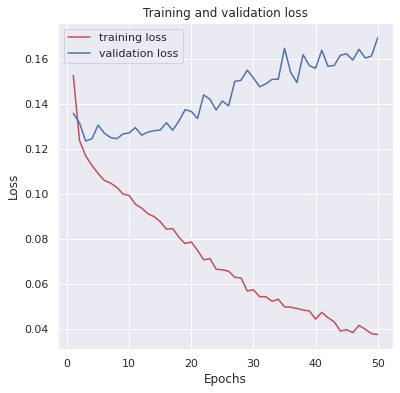

In [ ]:
# look at the graphs of the error change by epoch
plt.clf()
history_dict = history.history
# get values ​​from the saved dictionary with history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'r', label='training loss')
plt.plot(epochs, val_loss_values, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


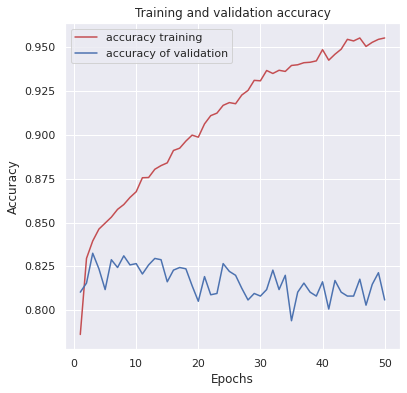

In [ ]:
# accuracy on the validation set
plt.clf()
# get values ​​from the saved dictionary with history

acc_values = history.history['binary_accuracy']

val_acc_values = history_dict['val_binary_accuracy']

epochs = range(1, (len(history_dict['binary_accuracy']) + 1))

# build graphs for accuracy on train and val
plt.plot(epochs, acc_values, 'r', label='accuracy training')
plt.plot(epochs, val_acc_values, 'b', label='accuracy of validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# we will get predictions from it according to the model
from sklearn.metrics import classification_report
predictions = model.predict(x_test)
print('The raw look of our predictions')
# round the predictions towards 0 or 1, comparing with the test
print(classification_report(y_test, np.around(predictions)))

The raw look of our predictions
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       679
           1       0.82      0.79      0.80       670

    accuracy                           0.81      1349
   macro avg       0.81      0.81      0.81      1349
weighted avg       0.81      0.81      0.81      1349



In [ ]:
# Save the model
model.save("Exoplanets.h5")

Saving the Neural Network model for deployment

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
model1 = load_model('Exoplanets.h5')
# summarize model.
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(model1.outputs)
print(model1.inputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>]
[<KerasTensor: shape=(None, 35) dtype=float32 (created by layer 'dense_input')>]


In [ ]:
x_test.shape

(1349, 35)

In [ ]:
results1 = model1.evaluate(x_test, y_test)

43/43 [==============================] - 0s 2ms/step - loss: 0.1629 - binary_accuracy: 0.8132


In [ ]:
print(model1.predict_on_batch(np.array([x_test[0:10],] )))
print(y_test[0:10])

[[[9.9941087e-01]
  [5.2152219e-04]
  [9.9718297e-01]
  [9.9998939e-01]
  [8.0568624e-01]
  [1.0000000e+00]
  [9.9811029e-01]
  [2.2137698e-02]
  [2.0323334e-05]
  [9.9866009e-01]]]
[1 1 1 1 0 1 0 0 0 1]


In [ ]:
len(x_test[0])

35